In [86]:
import numpy as np 
import pandas as pd 
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

Read in the data and scale pixel values from [0,255] to [0,1].

(33600, 784)
(8400, 784)
(28000, 784)


<AxesSubplot:ylabel='count'>

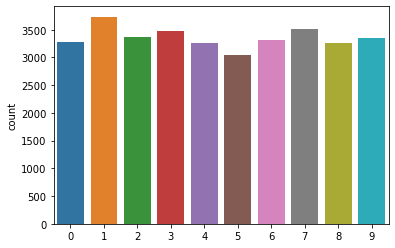

In [87]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X_train = train.iloc[:,1:].values/255 
y_train = train.iloc[:,0].values

X_val = X_train[33600:]
y_val = y_train[33600:]
X_train = X_train[:33600]
y_train = y_train[:33600]

X_test = test.values/255

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
sn.countplot(x = y_train)


Plot some sample images from the data (train and test).

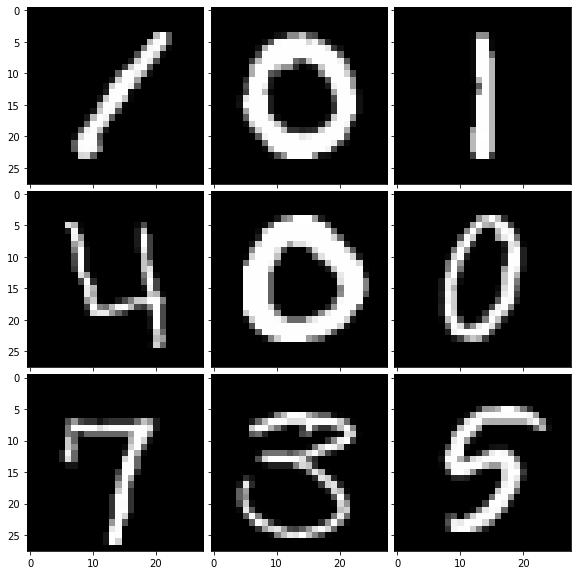

In [88]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(len(grid)):
    grid[i].imshow(X_train[i].reshape(28,28), cmap = 'gray')
    

Reshape to matrices since we will be using a CNN.

In [89]:
X_train = np.array([img.reshape(28,28) for img in X_train])
X_val = np.array([img.reshape(28,28) for img in X_val])
X_test = np.array([img.reshape(28,28) for img in X_test])

We will do some data augmentation in the hopes this will help the model classify more difficult examples, in particular due to varied orientation. Since there is generally some level of padding on these images, adding some small random rotations should work well as we can safely just pad the edges with black pixels to make room for a rotation. We will only consider small rotations as all digits are written the right way up, so any rotational differences will be small. In particular we do not need to anticipate for example an upsided down digit being classified. We will construct augmented datasets for rotations of (degrees): $\pm 10,\pm20$. 

To do this we first pad the original image with a border of zeros to make room for the rotation. Then let $(x,y)$ be coordinates of a point in the padded image, taken with respect to the centre of the image. The rotated image will be obtained by taking the values at the following coordinates from the padded image:

$$\begin{pmatrix}
x_\text{rot} \\ y_\text{rot}
\end{pmatrix}
:=
\begin{pmatrix}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta \\
\end{pmatrix}
\begin{pmatrix}
x \\ y 
\end{pmatrix}$$

as $(x,y)$ ranges over all coordinates within the padded image corresponding to points from the original image.

In practice these new coordinates will not be integers so we need to interpolate them. For each desired pixel value $(x_\text{rot}, y_\text{rot})$ we let $x_0 = \lfloor x_\text{rot}\rfloor$, $x_1 = \lceil x_\text{rot}\rceil$ and similarly define $y_0$, $y_1$. We also let $x_{-} = x_\text{rot} - x_0$,  $x_{+} = x_1 - x_\text{rot}$ and again similarly define $y_{-}, y_{+}$. Then letting $I(x,y)$ denote the pixel value at a point $(x,y)$ we approximate the desired value:

$$ I(x_\text{rot}, y_\text{rot}) = I(x_0,y_0)*x_{+}*y_{+} + I(x_0,y_1)*x_{+}*y_{-} + I(x_1,y_0)*x_{-}*y_{+} + I(x_1,y_1)*x_{-}*y_{-}$$

This is implemented below with examples following to show the effect. There is a slight smoothing effect due to this interpolation, but this augmentation still seems to improve generalisation when used in a model.

In [90]:
import math

def rotate(img, degrees):
    # pad the image with enough zeros to make room for rotation (Note: For larger rotations you may need more padding)
    tmp = np.zeros((40,40)) 
    tmp[6:34, 6:34] = img
    
    # with this reshaping we have (i,j)->(i+j*40)
    tmp = tmp.reshape(1600,)
    
    # zip(i,j) would give the indices for the original image, so i+j*40 gives the indices of the orignal image within the tmp vector
    i = list(range(6,34))*28
    j = np.array(sorted(i)).astype(int)
    i = np.array(i).astype(int)
    
    a = math.radians(degrees)
    
    # (i,j) pixel in new image is given by (i_rotated, j_rotated) from the old one
    # 20.5 adjustment since we need to take coordinates with respect to the centre 
    i_rotated = (i-20.5)*np.cos(a) + (j-20.5)*np.sin(a) + 20.5
    j_rotated = -(i-20.5)*np.sin(a) + (j-20.5)*np.cos(a) + 20.5
    
    # Linearly interpolate to get the desired pixel value, as described above
    i0 = np.floor(i_rotated).astype(int)
    i1 = np.ceil(i_rotated).astype(int)
    lambda_i = i_rotated-i0
    j0 = np.floor(j_rotated)
    j1 = np.ceil(j_rotated)
    lambda_j = j_rotated-j0
    rotated = tmp[(i0+j0*40).astype(int)] * (1-lambda_i) * (1-lambda_j) + tmp[(i0+j1*40).astype(int)] * (1-lambda_i) * lambda_j + tmp[(i1+j0*40).astype(int)] * lambda_i * (1-lambda_j) + tmp[(i1+j1*40).astype(int)] * lambda_i * lambda_j
    
    return(rotated.reshape(28,28))
    

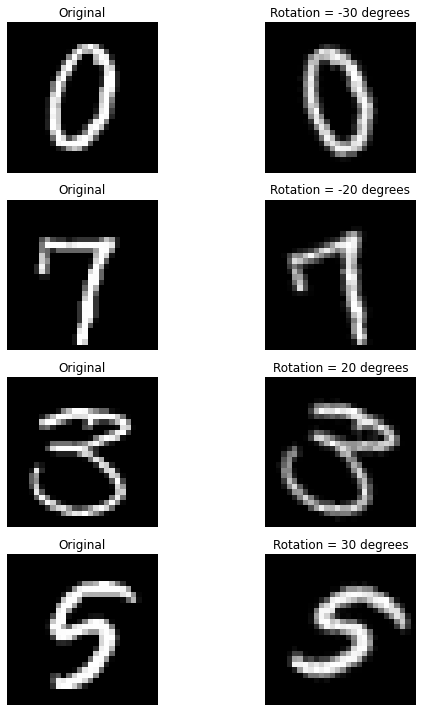

In [91]:
angles = [-30,-20,20,30]
plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(4, 2, 2*i-1)
    plt.imshow(X_train[i+4], cmap = "gray")
    plt.title('Original')
    plt.axis('off')

    
    plt.subplot(4, 2, 2*i)
    plt.imshow(rotate(X_train[i+4], angles[i-1]), cmap = "gray")
    plt.axis('off')
    plt.title('Rotation = ' + str(angles[i-1]) + ' degrees')
    plt.tight_layout()


As was mentioned above, the interpolation leads to a smoothing effect. We can try to combat this by trying to resharpen the rotated image before returning it. We will define another version of the rotate function where we make such an adjustment. We make any pixel values in $(0,0.5)$ smaller by an amount proportional to their distance from 0.5, and similarly make any pixel values in $(0.5,1)$ larger by an amount proportional to their distance from 0.5. The only difference in the rotate_sharpen function below from rotate above is the final block of code before the return statement.

We also define a sharpen function which has the property that sharpen(rotate(X)) = rotate_sharpen(X). The reason is that below we want to consdier both augmentations so we will have already computed the rotated dataset. It will be quicker to just sharpen this data than to go back to the original data to rotate and sharpen it.

In [105]:
def rotate_sharpen(img, degrees):
    # pad the image with enough zeros to make room for rotation (Note: For larger rotations you may need more padding)
    tmp = np.zeros((40,40)) 
    tmp[6:34, 6:34] = img
    
    # with this reshaping we have (i,j)->(i+j*40)
    tmp = tmp.reshape(1600,)
    
    # zip(i,j) would give the indices for the original image, so i+j*40 gives the indices of the orignal image within the tmp vector
    i = list(range(6,34))*28
    j = np.array(sorted(i)).astype(int)
    i = np.array(i).astype(int)
    
    a = math.radians(degrees)
    
    # (i,j) pixel in new image is given by (i_rotated, j_rotated) from the old one
    # 20.5 adjustment since we need to take coordinates with respect to the centre 
    i_rotated = (i-20.5)*np.cos(a) + (j-20.5)*np.sin(a) + 20.5
    j_rotated = -(i-20.5)*np.sin(a) + (j-20.5)*np.cos(a) + 20.5
    
    # Linearly interpolate to get the desired pixel value, as described above
    i0 = np.floor(i_rotated).astype(int)
    i1 = np.ceil(i_rotated).astype(int)
    lambda_i = i_rotated-i0
    j0 = np.floor(j_rotated)
    j1 = np.ceil(j_rotated)
    lambda_j = j_rotated-j0
    rotated = tmp[(i0+j0*40).astype(int)] * (1-lambda_i) * (1-lambda_j) + tmp[(i0+j1*40).astype(int)] * (1-lambda_i) * lambda_j + tmp[(i1+j0*40).astype(int)] * lambda_i * (1-lambda_j) + tmp[(i1+j1*40).astype(int)] * lambda_i * lambda_j
    
    for k in range(len(rotated)):
        if rotated[k] > 0.5:
            rotated[k] += 0.5*(1-rotated[k])
        elif rotated[k] < 0.5:
            rotated[k] -= 0.5*(rotated[k])
    
    return(rotated.reshape(28,28))

def sharpen(X):
    shape = X.shape
    for j in range(shape[0]):
        img = X[j].flatten()
        for k in range(len(img)):
            if img[k] > 0.5:
                img[k] += 0.5*(1-img[k])
            elif img[k] < 0.5:
                img[k] -= 0.5*(img[k])
        X[j] = img.reshape((shape[1], shape[2]))
    return X

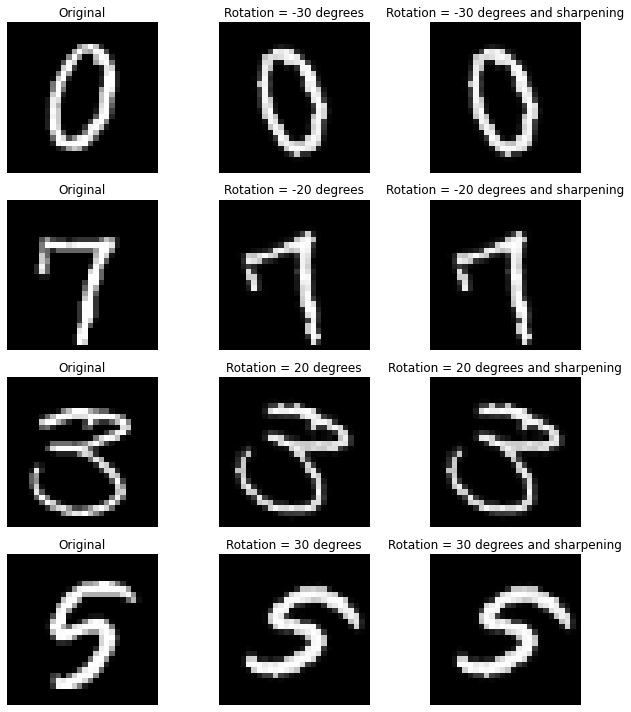

In [107]:
plt.figure(figsize=(10,10))

for i in range(1,5):
    plt.subplot(4, 3, 3*i-2)
    plt.imshow(X_train[i+4], cmap = "gray")
    plt.title('Original')
    plt.axis('off')

    
    plt.subplot(4, 3, 3*i-1)
    plt.imshow(sharpen(np.array([rotate(X_train[i+4], angles[i-1])]))[0], cmap = "gray")
    plt.axis('off')
    plt.title('Rotation = ' + str(angles[i-1]) + ' degrees')
    
    plt.subplot(4, 3, 3*i)
    plt.imshow(rotate_sharpen(X_train[i+4], angles[i-1]), cmap = "gray")
    plt.axis('off')
    plt.title('Rotation = ' + str(angles[i-1]) + ' degrees and sharpening')
    plt.tight_layout()

We will compare model performance for 3 cases:
* Original Data
* Original Data + Rotated Versions
* Orignal Data + Rotated & Sharpened Versions

Note that we don't sharpen the original data, only the rotated data. This is because we do not actually want to sharpen the data since the test images will not be sharpened (although we could potentially try a model with sharpening included as part of the model). Rather the reason we are sharpening is in an attempt to undo the smoothing introduced by the rotation. 

In [99]:
# Construct dataset with rotations
X_train_10a = np.array([rotate(img,10) for img in X_train])
X_train_10b = np.array([rotate(img,-10) for img in X_train])
X_train_20a = np.array([rotate(img,20) for img in X_train])
X_train_20b = np.array([rotate(img,-20) for img in X_train])

X_train_rot = np.concatenate((X_train, X_train_10a, X_train_10b, X_train_20a, X_train_20b))

# X needs to have an extra dimension
X_train_rot = X_train_rot.reshape(5*X_train.shape[0],28,28,1)

# y needs to be one hot encoded
temp = np.zeros((y_train.size, y_train.max()+1))
temp[np.arange(y_train.size),y_train] = 1
y_train = temp
y_train_rot = np.concatenate((y_train, y_train, y_train, y_train, y_train))

In [100]:
# Construct dataset with rotations and sharpening
X_train_10a = np.array([rotate_sharpen(img,10) for img in X_train])
X_train_10b = np.array([rotate_sharpen(img,-10) for img in X_train])
X_train_20a = np.array([rotate_sharpen(img,20) for img in X_train])
X_train_20b = np.array([rotate_sharpen(img,-20) for img in X_train])

X_train_rot_shp = np.concatenate((X_train, X_train_10a, X_train_10b, X_train_20a, X_train_20b))
X_train_rot_shp = X_train_rot_shp.reshape(5*X_train.shape[0],28,28,1)

y_train_rot_shp = y_train_rot

In [113]:
# The same format changes we made to the augmented datasets above will be needed in the original data if we wish to fit a model with just that 
# y_train has already been one hot encoded in doing so for the augmented data but X_train has not been reshaped
# also neither of the validation sets have been reshaped

X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_val = X_val.reshape(X_val.shape[0],28,28,1)

temp = np.zeros((y_val.size, y_val.max()+1))
temp[np.arange(y_val.size),y_val] = 1
y_val = temp

Now start building a CNN. We try 3 convolutional layers with dropout ($p=0.4$). Each of the first two is followed by a 2x downsample via max pooling and the number of filters doubles each layer 32->64->128. After this the output of the final convolutional layer is flattened and passes through a dense softmax layer to compute the class probabilities.

In [137]:
# Fit model with original data

l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')
l5 = tf.keras.layers.Dropout(rate = 0.4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')
l8 = tf.keras.layers.Dropout(rate = 0.4)
l9 = tf.keras.layers.Flatten()
l10 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model_original = tf.keras.Sequential([l1,l2,l3,l4,l5,l6,l7,l8,l9, l10])
model_original.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])

# train with original data
histories_original = model_original.fit(X_train, y_train, epochs = 50, batch_size = 128, validation_data = (X_val, y_val))

Epoch 1/50
263/263 [==============================] - 2s 7ms/step - loss: 0.7085 - acc: 0.7740 - val_loss: 0.1776 - val_acc: 0.9743
Epoch 2/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0977 - acc: 0.9696 - val_loss: 0.1251 - val_acc: 0.9848
Epoch 3/50
263/263 [==============================] - 2s 7ms/step - loss: 0.0676 - acc: 0.9793 - val_loss: 0.0976 - val_acc: 0.9815
Epoch 4/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0557 - acc: 0.9818 - val_loss: 0.0616 - val_acc: 0.9888
Epoch 5/50
263/263 [==============================] - 2s 7ms/step - loss: 0.0453 - acc: 0.9856 - val_loss: 0.0689 - val_acc: 0.9885
Epoch 6/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0376 - acc: 0.9882 - val_loss: 0.0622 - val_acc: 0.9898
Epoch 7/50
263/263 [==============================] - 2s 6ms/step - loss: 0.0330 - acc: 0.9882 - val_loss: 0.0485 - val_acc: 0.9901
Epoch 8/50
263/263 [==============================] - 2s 6ms/step - loss: 0.

In [138]:
# Fit model with rotated data

l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')
l5 = tf.keras.layers.Dropout(rate = 0.4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')
l8 = tf.keras.layers.Dropout(rate = 0.4)
l9 = tf.keras.layers.Flatten()
l10 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model_rot = tf.keras.Sequential([l1,l2,l3,l4,l5,l6,l7,l8,l9, l10])
model_rot.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])

# train with original data
histories_rot = model_rot.fit(X_train_rot, y_train_rot, epochs = 50, batch_size = 128, validation_data = (X_val, y_val))

Epoch 1/50
1313/1313 [==============================] - 8s 5ms/step - loss: 0.3558 - acc: 0.8869 - val_loss: 0.0777 - val_acc: 0.9870
Epoch 2/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0604 - acc: 0.9808 - val_loss: 0.0433 - val_acc: 0.9905
Epoch 3/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0443 - acc: 0.9854 - val_loss: 0.0395 - val_acc: 0.9908
Epoch 4/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0380 - acc: 0.9873 - val_loss: 0.0388 - val_acc: 0.9914
Epoch 5/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0329 - acc: 0.9891 - val_loss: 0.0316 - val_acc: 0.9933
Epoch 6/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0297 - acc: 0.9901 - val_loss: 0.0309 - val_acc: 0.9926
Epoch 7/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0259 - acc: 0.9913 - val_loss: 0.0280 - val_acc: 0.9931
Epoch 8/50
1313/1313 [==============================] - 7s 5ms

In [139]:
# Fit model with rotated and sharpened data

l1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1))
l2 = tf.keras.layers.Dropout(rate = 0.4)
l3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l4 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')
l5 = tf.keras.layers.Dropout(rate = 0.4)
l6 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')
l7 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')
l8 = tf.keras.layers.Dropout(rate = 0.4)
l9 = tf.keras.layers.Flatten()
l10 = tf.keras.layers.Dense(units = 10, activation = 'softmax')
model_rot_shp = tf.keras.Sequential([l1,l2,l3,l4,l5,l6,l7,l8,l9, l10])
model_rot_shp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["acc"])

# train with original data
histories_rot_shp = model_rot_shp.fit(X_train_rot_shp, y_train_rot_shp, epochs = 50, batch_size = 128, validation_data = (X_val, y_val))

Epoch 1/50
1313/1313 [==============================] - 8s 6ms/step - loss: 0.3591 - acc: 0.8826 - val_loss: 0.0811 - val_acc: 0.9883
Epoch 2/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0644 - acc: 0.9798 - val_loss: 0.0509 - val_acc: 0.9901
Epoch 3/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0493 - acc: 0.9845 - val_loss: 0.0424 - val_acc: 0.9908
Epoch 4/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0425 - acc: 0.9864 - val_loss: 0.0394 - val_acc: 0.9918
Epoch 5/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0358 - acc: 0.9879 - val_loss: 0.0376 - val_acc: 0.9919
Epoch 6/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0325 - acc: 0.9893 - val_loss: 0.0315 - val_acc: 0.9929
Epoch 7/50
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0289 - acc: 0.9903 - val_loss: 0.0288 - val_acc: 0.9919
Epoch 8/50
1313/1313 [==============================] - 7s 5ms

In [140]:
original_argmax = np.argmax(histories_original.history["val_acc"])
rot_argmax = np.argmax(histories_rot.history["val_acc"])
rot_shp_argmax = np.argmax(histories_rot_shp.history["val_acc"])

print('Original Data Best Validation: ', histories_original.history["val_acc"][original_argmax])
print(' Train - Val at Best Validation: ', histories_original.history["acc"][original_argmax] - histories_original.history["val_acc"][original_argmax])

print('\nRotated Data Best Validation: ', histories_rot.history["val_acc"][rot_argmax])
print(' Train - Val at Best Validation: ', histories_rot.history["acc"][rot_argmax] - histories_rot.history["val_acc"][rot_argmax])

print('\nRotated & Sharpened Data Best Validation: ', histories_rot.history["val_acc"][rot_shp_argmax])
print(' Train - Val at Best Validation: ', histories_rot.history["acc"][rot_shp_argmax] - histories_rot.history["val_acc"][rot_shp_argmax])

Original Data Best Validation:  0.993571400642395
 Train - Val at Best Validation:  0.0030655264854431152

Rotated Data Best Validation:  0.9952380657196045
 Train - Val at Best Validation:  -0.00042259693145751953

Rotated & Sharpened Data Best Validation:  0.9944047331809998
 Train - Val at Best Validation:  0.0018214583396911621


### Disccussion

The goal of the data augmentation is to improve generalisation performance and overall performance too. From the above results we see it is clearly achieving this goal. In both augmented data cases the best validation accuracy achieved is better than that with just the original data, and the reduction in accuracy from training to validation is less. i.e. The augmented data modles perform better **and** generalise better. 

In terms of the two types of augmentations, rotation alone performs noticeably better than rotation and sharpening, in terms of both overall performance and generalisation (in fact the rotated version seemsto consistently do better on validation than on train). This is likely down to the fact that the sharpening introduces a slight inconsistency between training and validation. Recall that the motivation for sharpening was not to have sharpened training data. Rather it was just to try to undo the smoothing caused by the rotation. However it is inevitably difficult to achieve this exactly, and so we do end up with data which is slightly sharpened in comparison to the original data, and therefore also in comparison to the validation and test data. As a result we are with data of which 80% of images are sharpened, even though we validate and test on images with no sharpening. 

A potentially interesting idea to investigate this would be to include a sharpening layer in the network. This was we can work with the rotated and sharpened data while having all of the training data, validation data and test data sharpened too. 

## Further Work

We will take the best performing model and look into which images are being misclassified. We find all misclassified image then plot the first 16 and compare true vs predictions.

In [142]:
y_labels = np.argmax(y_val, axis = 1)
train_predictions = np.argmax(model_rot.predict(X_val), axis = 1)
misclassified = [i for i in range(len(y_labels)) if y_labels[i] != train_predictions[i]]

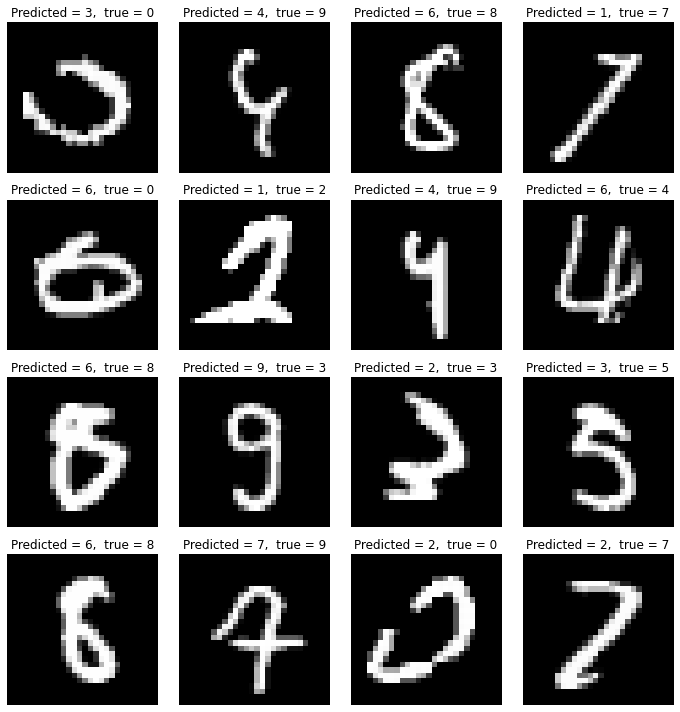

In [145]:
# first 16 misclassifications

fig = plt.figure(figsize=(10., 10.))
for i in range(1,17):
    ind = misclassified[i-1]
    plt.subplot(4,4,i)
    plt.imshow(X_val[ind].reshape(28,28), cmap = 'gray')
    plt.axis('off')
    plt.title('Predicted = ' + str(train_predictions[ind]) + ',  true = ' + str(y_labels[ind]))
    plt.tight_layout()


The majority of these misclassifications seem quite reasonable, we can clearly understand why the particular wrong label was assigned. For example we have 9 and 4 commonly mixed up when the top of the 9 is not joined, 8 with the top opening not very clear misclassified as 6. In fact many of these examples could not even be classified with a lot of confidence by eye. As a result I'm not really sure that much can be done to overcome these misclassifications, and more importantly correctly classify similar examples in the test set. There will always be some samples which are ambiguous even to the human eye and the model can probably be expected to struggle with these.

In [ ]:
# produce submission file

# probas = model_rot.predict(X_test_rot.reshape((len(X_test_rot),28,28,1)))
# pred = [np.argmax(prob) for prob in probas]
# pred = pd.DataFrame({'ImageID': list(range(1,len(pred)+1)), 'Label': pred})
# pred.set_index('ImageID', inplace = True)
# pred.to_csv('submission_aug.csv')

### Next

* Use tuner to take best validation model from all epochs
* Try model with sharpening layer
* Vary model architecture: more layers, vary number of filters, dense layers, downsampling
* Other Finetuning: Vary training parameters (epochs, learning, rate, optimizer etc.)
* Other Methods: Try classical methods like knn, trees possibly combined with PCA


## Summary

Best Test Accuracy Achieved: 0.99489 with model_rot

Our original model used two convolutional layers with 32 filters and no downsampling, each with dropout. This more complex still uses convolutional layers and dropout. However we now have 3 convolutional layers, and we downsample the images (28->14->7) while increasing the number of filters (32->64->128) throughout. This is the best performance so far by around 0.006 or 0.6%. It is worth noting this model also shows the smallest difference in training vs test accuracy (around 0.1%). It seems that the incorporation of downsampling and/or more feature maps allows the model to learn more generalisable representations of the images, leading to less deterioration in performance on the test data.